### Extending earlier `participant-targeting-differences` analysis (from pilot) to see targeting differences from Survey 1's annotated ads

In [1]:
import csv, json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats
plt.rcParams['font.family'] = 'Helvetica'
import matplotlib.lines as mlines
from math import sqrt
import numpy as np
import pandas as pd

In [3]:
# load targetings
ad_targetings = {}
with open('../../db-processing/ad-targetings.tsv', 'r') as fh:
    for line in fh:
        ad_id, targeting = line.split('\t')
        targeting = json.loads(targeting.strip())
        ad_targetings[ad_id] = targeting

In [4]:
from collections import defaultdict

def count_code_props(codes, norm=True):
    # takes dict from adid -> codes and returns dict of code proportions
    counts = defaultdict(lambda: 0)
    for aid in codes:
        # in case of multiple codes, count each one -- essentially computing fraction of codes and not ads here
        for code in codes[aid].split(';'):
#             if code not in ['Political', 'Clickbait']:
            if code not in ['Political']:
                counts[code] += 1
                
    if norm:
        return {c: counts[c]/sum(counts.values()) for c in counts}
    else:
        return counts
    
def find_code_ads(codes):
    # takes dict from adid -> codes and inverts it to return code -> [adid] dict
    # input dict can be computed e.g. by dict(codes[['adid', 'codes_angelica']].values)
    flipped = defaultdict(list)
    for aid in codes:
        for code in codes[aid].split(';'):
            if code not in ['Political']:
                flipped[code].append(aid)
                
    return flipped

In [5]:
# load PID, AD_ID mapping
pid_adid_files = ['../../db-processing/surveys/survey-1/pid_adid_survey1.tsv',
                 '../../db-processing/surveys/survey-2/pid_adid_survey2.tsv']
pid_adid = pd.read_csv(pid_adid_files[0], sep='\t')
for f in pid_adid_files[1:]:
    pid_adid = pd.concat([pid_adid, pd.read_csv(f, sep='\t')], ignore_index=True)
print(pid_adid.shape)
survey1_pids = set(pid_adid['pid'])

codes_file = '../../db-processing/ad_codes.tsv'
codes = pd.read_csv(codes_file, sep='\t')
# copy over Angelica's missing codes from Ali
ang_null = codes['codes_angelica'].isna()
codes.loc[ang_null, 'codes_angelica'] = codes.loc[ang_null, 'codes_ali']

# load codes and compute user-level fractions too
part_code_props = {}
part_code_counts = {}

for pid in survey1_pids:
    joiner = pid_adid[pid_adid['pid'] == pid]
    joined = joiner.merge(codes, how='inner', left_on='adid', right_on='adid')
    
    code_props = count_code_props(dict(joined[['adid', 'codes_angelica']].values), norm=True)
    part_code_props[pid] = code_props
    
    code_counts = count_code_props(dict(joined[['adid', 'codes_angelica']].values), norm=False)
    part_code_counts[pid] = code_counts

(15232, 2)


In [9]:
ca_advertisers = {}
# 'ca_owner_name': 'Klarna'

def get_targeting(ut, aid):
    # also updates global list of CA advertisers
    global ca_advertisers
    
    # there is always an el['__typename'] == 'WAISTUIAgeGenderType'
    all_targetings = {'id': aid}
    for el in ut['data']['waist_targeting_data']:
        if el['__typename'] == 'WAISTUIInterestsType':
            all_targetings['interests'] = set([i['name'] for i in el['interests']])
        elif el['__typename'] == 'WAISTUICustomAudienceType':
            ca_advertisers[aid] = el['dfca_data']['ca_owner_name']
            all_targetings['custom'] = True
        elif el['__typename'] == 'WAISTUILocationType':
            gran = json.loads(el['serialized_data'])['location_granularity']
            loc = el['location_name']
            all_targetings['location'] = {'loc': loc, 'gran': gran}
        elif el['__typename'] == 'WAISTUIAgeGenderType':
            all_targetings['age-gender'] = {
                'age_min': el['age_min'],
                'age_max': el['age_max'],
                'gender': el['gender']
            }        
        
    return all_targetings

In [ ]:
# QUESTIONS WORTH LOOKING AT
# 1. how different is targeting by code?
# 2. how different is targeting by user? (can be compared to their non-benign ratio) -- DONE
# 3. any specific peculiarities with the negative codes? 

In [10]:
# pull out all targeting interests seen in the data
user_interests = defaultdict(list)
user_targetings = defaultdict(list)
for uid in survey1_pids:
    for aid in pid_adid[pid_adid['pid'] == uid]['adid']:
        # process targeting json to extract info
        tar = get_targeting(ad_targetings[str(aid)], aid)
        user_targetings[uid].append(tar)
        if 'interests' in tar:
            user_interests[uid].extend(list(tar['interests']))

In [11]:
user_targetings['6112cec057db665aefdd7a85']

[{'id': 23848721522540460,
  'interests': {"Tilly's"},
  'age-gender': {'age_min': 6, 'age_max': 53, 'gender': 'ANY'},
  'location': {'loc': 'the United States', 'gran': 'country'}},
 {'id': 6254413481299,
  'age-gender': {'age_min': 9, 'age_max': 53, 'gender': 'ANY'},
  'location': {'loc': 'the United States', 'gran': 'country'}},
 {'id': 23849178994590365,
  'custom': True,
  'age-gender': {'age_min': 6, 'age_max': 53, 'gender': 'ANY'},
  'location': {'loc': 'the United States', 'gran': 'country'}},
 {'id': 23849587673510743,
  'age-gender': {'age_min': 6, 'age_max': 53, 'gender': 'ANY'},
  'location': {'loc': 'the United States', 'gran': 'country'}},
 {'id': 6282218739351,
  'interests': {'Beauty', 'Health & wellness'},
  'age-gender': {'age_min': 6, 'age_max': 22, 'gender': 'FEMALE'},
  'location': {'loc': 'the United States', 'gran': 'country'}},
 {'id': 6266244850944,
  'age-gender': {'age_min': 6, 'age_max': 31, 'gender': 'FEMALE'},
  'location': {'loc': 'Florida', 'gran': 'regi

In [12]:
# helpers to pull out info from targeting dict
tar_interest = lambda uid: sum([1 for t in user_targetings[uid] if 'interests'in t])
tar_custom = lambda uid: sum([1 for t in user_targetings[uid] if 'custom' in t])

In [13]:
for uid in user_interests:
    freqs = Counter(user_interests[uid])
    total = pid_adid[pid_adid['pid'] == uid].shape[0]
    print('--', uid, '--')
    print(f'Total: {total}')
#     custom = sum([1 for t in user_targetings[uid] if 'custom' in t])
    custom = tar_custom(uid)
    user_ads = list(pid_adid[pid_adid['pid'] == uid]['adid'])
    print(f'custom: {custom} ({round(custom/total * 100, 2)}%)\
        {[ca_advertisers[aid] for aid in user_ads if aid in ca_advertisers]}')
    interest_targeted = tar_interest(uid)
    generic = total - custom - interest_targeted
    print(f'interest: {interest_targeted} ({round(interest_targeted/total * 100, 2)}%)')
    print(f'generic: {generic} ({round(generic/total * 100, 2)}%)\n')

-- 60bd88b8fc436774352f53b9 --
Total: 81
custom: 38 (46.91%)        ['Bisoulovely', "Woodstock's Pizza", 'FarmacyBeauty', 'Ana Luisa', 'Nipppy Co', 'FarmacyBeauty', 'Bluefocus', 'Ana Luisa', 'Ana Luisa', 'Aavrani', 'FaceTory', 'Gymshark', 'StriVectin', 'Aavrani', 'Aavrani', 'Stanford Continuing Studies', 'Aavrani', 'Aavrani', 'Aavrani', "Paula's Choice", "Paula's Choice", "Paula's Choice", 'Codecademy', 'Codecademy', 'Glossier', 'Glossier', 'Nipppy Co', 'Bluefocus', "Victoria's Secret", 'Ulta Beauty', 'Bluefocus', 'StriVectin', 'EM Cosmetics', 'Essie', 'Ana Luisa', 'Ana Luisa', 'SEPHORA', 'Bubble']
interest: 14 (17.28%)
generic: 29 (35.8%)

-- 805102 --
Total: 226
custom: 47 (20.8%)        ['Nate', 'Science 37', 'Thriveworks', 'Thumbtack', 'USO', 'Neighbor', 'SmartAsset.com', 'PeytonDigital', 'Viking', 'Harris Teeter', 'Harris Teeter', 'Clinical Leads', 'MaxSold', 'PCH Publishers Clearing House', 'PCH Publishers Clearing House', 'EF Go Ahead Tours', 'Heifer International', 'DKS Startup

-- 250672 --
Total: 139
custom: 40 (28.78%)        ['Two Blind Brothers', 'StylusFlex', 'Scribd', 'MS TECH Solutions', 'Native', 'Squishable Advertising', 'World Wildlife Fund', 'Beau Ties of Vermont', 'DirtyBird Energy', 'Brentwood Home', 'GNC Live Well', 'FREY', 'Panty Drop', 'Panty Drop', 'Anicura', 'Catit', 'SideChef', 'Party Makers, Inc.', 'SideChef', '40 Below Joe', 'Backdrop', 'Tame the Beast', 'tooktake', 'Huel', 'Nestlé', 'Why Bars', 'Taza Chocolate', "L'Oreal Usa, Inc.", "L'Oreal Usa, Inc.", 'Musgrave Pencil Co, Inc.', 'Wholier', 'Vital Sleep', "Tom Bishop's Business Account", 'Intact America', 'Catisphere', 'Enventys Partners', 'Bluefocus', 'HelloFresh', 'OolloO', 'Lilova']
interest: 51 (36.69%)
generic: 48 (34.53%)

-- 5dd40277e08a363e4e006384 --
Total: 98
custom: 38 (38.78%)        ['ReserveBar', 'ColourPop', 'Zimmerman Advertising', 'Ty', 'Ty', 'Til Valhalla Project', 'Ty', 'Xtreme Xperience', 'Capital One Shopping', 'Nickelodeon', 'TeeTurtle', 'Capital One Shopping', 'Wa

-- 5e861812b23b0a22ef59c4ee --
Total: 66
custom: 25 (37.88%)        ['Ulta Beauty', 'Ulta Beauty', 'Coach', 'Ulta Beauty', "L'Oreal Usa, Inc.", 'Kendra Scott', "L'Oreal Usa, Inc.", 'BrüMate', 'Smashbox Cosmetics', 'TOMS', 'The Home Depot', 'Peloton', 'Urban Decay US', 'QVC', 'Old Navy', 'Lulus', "L'Oreal Usa, Inc.", 'The Home Depot', 'Ulta Beauty', 'BrüMate', 'Coach', 'Dagne Dover', 'PDPAOLA', 'Kendra Scott', 'Ulta Beauty']
interest: 4 (6.06%)
generic: 37 (56.06%)

-- 614254 --
Total: 28
custom: 9 (32.14%)        ['CitizenShipper', 'Sequencing', 'Capital One Shopping', 'USCCA', 'Antidote.me', 'Shopify', 'Lucid', 'Amobee DMP', 'Roche Diagnostics USA']
interest: 12 (42.86%)
generic: 7 (25.0%)

-- 5e5ab88a43f33029b119a48c --
Total: 86
custom: 9 (10.47%)        ['Hungryroot', 'Purdue University Global', 'Thinx', 'Faraday', 'Match', 'Evelyn & Bobbie', 'Simple App', 'Have Your Cake and Eat It Too', 'Noom HQ']
interest: 3 (3.49%)
generic: 74 (86.05%)

-- 5f3e5e066dfaa70464615447 --
Total: 131

In [14]:
from math import sqrt

def normal_bin_conf(p, n, alpha=.95):
    tab = {0.90: 1.645, 0.95: 1.96, 0.99: 2.58}
    z = tab[alpha]
    # binomial proportion confidence interval
    return z * sqrt((p * (1-p))/n)

### Targeting Differences by User/Participant

Text(0.5, 0, 'Participant')

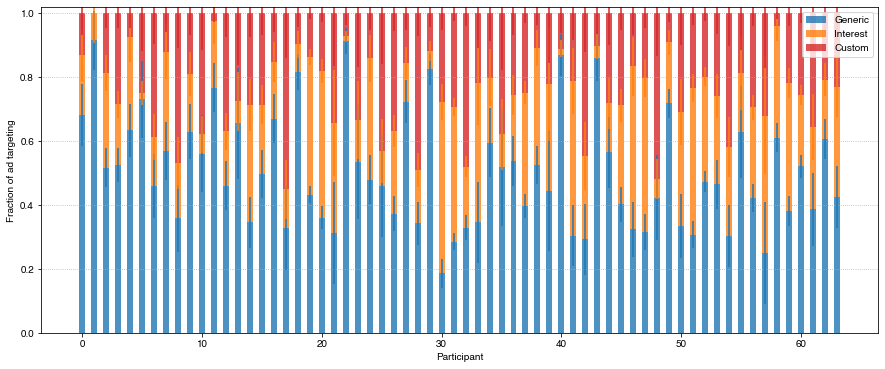

In [15]:
# PLOTTING USER LEVEL STACKED BAR PLOT
custom_total, generic_total, interest_total = 0, 0, 0
f, axs = plt.subplots(1, 1, figsize=(15, 6))
colors = ['tab:blue', 'tab:orange', 'tab:red']
labels = ['Generic', 'Interest', 'Custom']

interest_fracs, custom_fracs, total_fracs = [], [], []
part_ad_counts = pid_adid.groupby('pid').count().to_dict()['adid']
last = np.zeros(len(survey1_pids))
part_order = sorted(survey1_pids, key=lambda pid: part_code_props[pid]['Benign'], reverse=True)
# exclude participants with < 25 ads
part_order = [p for p in part_order if part_ad_counts[p] >= 25]

for i, uid in enumerate(part_order):
    total = pid_adid[pid_adid['pid'] == uid].shape[0]
    interest_targeted = tar_interest(uid)
    custom = tar_custom(uid)
    generic = total - interest_targeted - custom
    interest_total += interest_targeted; custom_total += custom; generic_total += generic
    
    # convert to fractions
    interest_targeted /= total; custom /= total; generic /= total    
    
#     err = [normal_bin_conf(curr[i], totals[p]) if (totals[p]*curr[i]) >= 5 else 0 \
#         for i, p in enumerate(hor_order)]
    last = 0
    for j, frac in enumerate([generic, interest_targeted, custom]):
        err = normal_bin_conf(frac, total)
        axs.bar([i], [frac], .5, bottom=last, ecolor=colors[j],
                  color=colors[j], alpha=.8, yerr=err, label=labels[j])
        labels[j] = ''
        last += frac
        
axs.legend()
axs.set_ylim(top=1.02)
axs.grid(ls=':', axis='y')
axs.set_ylabel('Fraction of ad targeting')
axs.set_xlabel('Participant')

# plt.savefig('targeting-differences-user.jpg', dpi=200, bbox_inches='tight')

### Targeting Differences by Code

In [16]:
# unpack by code
code_ads = find_code_ads(dict(codes[['adid', 'codes_angelica']].values))

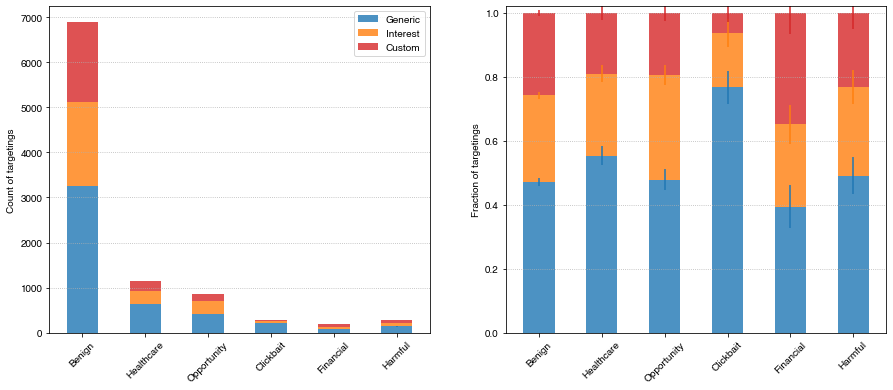

In [18]:
plot_codes = ['Benign', 'Healthcare', 'Opportunity', 'Clickbait', 'Financial', 'Harmful']
f, axs = plt.subplots(1, 2, figsize=(15, 6))

labels = ['Generic', 'Interest', 'Custom']
for i, c in enumerate(plot_codes):    
    n_interest, n_custom, n_generic = 0, 0, 0
    if c == 'Harmful':
        total = len(code_ads['Potentially Prohibited']) + len(code_ads['Potentially Harmful'])
        curr_code_ads = code_ads['Potentially Prohibited'] + code_ads['Potentially Harmful']
    else:
        total = len(code_ads[c])
        curr_code_ads = code_ads[c]        
        
    for aid in curr_code_ads:
        # preprocess targeting json
        tar = get_targeting(ad_targetings[str(aid)], aid)
        if 'interests' in tar:
            n_interest += 1
        if 'custom' in tar:
            n_custom += 1

    n_generic = total - n_interest - n_custom
            
    # counts on left plot
    last = 0
    for j, count in enumerate([n_generic, n_interest, n_custom]):
        axs[0].bar([i], [count], .5, bottom=last, ecolor=colors[j],
                  color=colors[j], alpha=.8, yerr=err, label=labels[j])
        labels[j] = ''
        last += count

    # fractions on right plot
    last = 0
    for j, frac in enumerate([n_generic/total, n_interest/total, n_custom/total]):
        err = normal_bin_conf(frac, total)
        axs[1].bar([i], [frac], .5, bottom=last, ecolor=colors[j],
                  color=colors[j], alpha=.8, yerr=err)
        
        last += frac
      
axs[0].legend()
axs[0].set_ylabel('Count of targetings')
axs[1].set_ylabel('Fraction of targetings')
axs[1].set_ylim(top=1.02)
for ax in axs:
    ax.grid(ls=':', axis='y')
    ax.set_xticks(range(len(plot_codes)))
    ax.set_xticklabels(plot_codes, rotation=45)
    
plt.savefig('targeting-differences-code-2.jpg', dpi=200, bbox_inches='tight')